# Adapting the Algorithm to a Multigraph

<img src="multigraph_network.png" alt="Turn Categorization Based on Angle" />

# Step 1: Create Graph Representation

In [1]:
import networkx as nx
import math
import pandas as pd
import random
import osmnx as ox
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import itertools
import numpy as np


c:\Users\Sneez\Desktop\Snowplowing\Snowplow-Routing-Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
edgelist = pd.read_csv("edges.csv")
nodelist = pd.read_csv("nodes.csv")

In [11]:
G = nx.MultiGraph()
for i,edges in edgelist.iterrows():
    G.add_edge(edges.iloc[0],edges.iloc[1],**edges.iloc[2:].to_dict())

for i,nodes in nodelist.iterrows():
    attributes = nodes[1:].to_dict()
    nx.set_node_attributes(G, {nodes['id']:  attributes})

In [28]:
print('# of edges: {}'.format(G.number_of_edges()))
print('# of nodes: {}'.format(G.number_of_nodes()))

print(G.edges(data=True))
print(G.nodes(data=True))

print(G)

# of edges: 7
# of nodes: 5
[(0, 2, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), (2, 1, {'distance': 1, 'priority': 3, 'time': 1, 'passes_rem': 2, 'salt_per': 1}), (2, 1, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), (2, 3, {'distance': 1, 'priority': 3, 'time': 1, 'passes_rem': 2, 'salt_per': 1}), (2, 3, {'distance': 1, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), (1, 4, {'distance': 2, 'priority': 2, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), (3, 4, {'distance': 2, 'priority': 2, 'time': 2, 'passes_rem': 1, 'salt_per': 1})]
[(0, {'x': 0, 'y': 0}), (2, {'x': 1, 'y': 1}), (1, {'x': 0, 'y': 2}), (3, {'x': 2, 'y': 0}), (4, {'x': 2, 'y': 2})]
MultiGraph with 5 nodes and 7 edges


In [29]:
def plot_multigraph(G, pos, title="Graph"):
    names = {name: name for name in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_color = 'lightgreen', node_size = 250, alpha = 1)
    nx.draw_networkx_labels(G,pos,names,font_size=12,font_color='b')
    ax = plt.gca()
    for e in G.edges:
        ax.annotate("",
                    xy=pos[e[1]], xycoords='data',
                    xytext=pos[e[0]], textcoords='data',
                    arrowprops=dict(arrowstyle="-", color="0",
                                    shrinkA=10, shrinkB=10,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                    ),
                                    ),
                    )
    plt.title(title)
    plt.axis('off')
    plt.show()


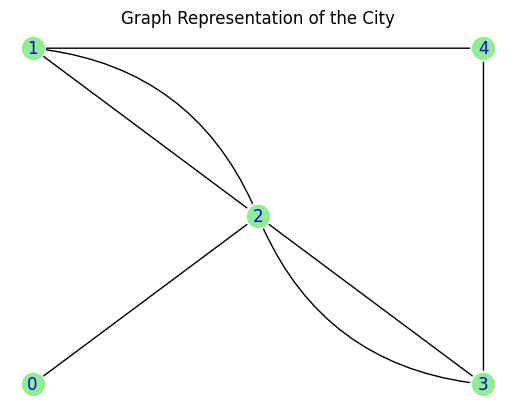

In [30]:

##### Visualize the Graph
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}
plot_multigraph(G, node_positions, "Graph Representation of the City")